# Imports

## Packages

In [1]:
import pandas as pd
import holidays
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

# import sklearn
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.decomposition import PCA

# Prophet model for time series forecast
# !pip install yfinance prophet

import warnings
warnings.filterwarnings('ignore')

Importing plotly failed. Interactive plots will not work.


In [2]:
from helper import *

## Data

In [3]:
df = pd.read_csv('./dataset_management/data/merged/merged.csv', parse_dates= ['Timestamp'])
df.head()

,Timestamp,DE_AT_LU,DE_LU,DK_1,SE_4,DE_AT_LU_Exports_Volume,DE_LU_Exports_Volume,DK_1_Exports_Volume,SE_4_Exports_Volume,Day_Ahead_Prices,Forecasted Load,Actual Load,Solar,Wind Offshore,Wind Onshore,TTF=F_Price,CFI2Z3_Price,CO2_prices_Price
0,2017-12-24 00:00:00,555.0,0.0,259.0,0.0,0.0,NaN,0.0,535.0,-40.84,1303.0,1302.0,0.0,201.0,498.0,NaN,NaN,NaN
1,2017-12-24 01:00:00,599.0,0.0,390.0,0.0,0.0,NaN,0.0,750.0,-43.18,1236.0,1252.0,0.0,204.0,506.0,NaN,NaN,NaN
2,2017-12-24 02:00:00,600.0,0.0,445.0,0.0,0.0,NaN,0.0,831.0,-50.04,1204.0,1230.0,0.0,203.0,511.0,NaN,NaN,NaN
3,2017-12-24 03:00:00,600.0,0.0,250.0,0.0,0.0,NaN,0.0,650.0,-42.31,1195.0,1194.0,0.0,202.0,513.0,NaN,NaN,NaN
4,2017-12-24 04:00:00,600.0,0.0,68.0,0.0,0.0,NaN,0.0,457.0,-40.09,1189.0,1179.0,0.0,202.0,497.0,NaN,NaN,NaN


# Pre-processing

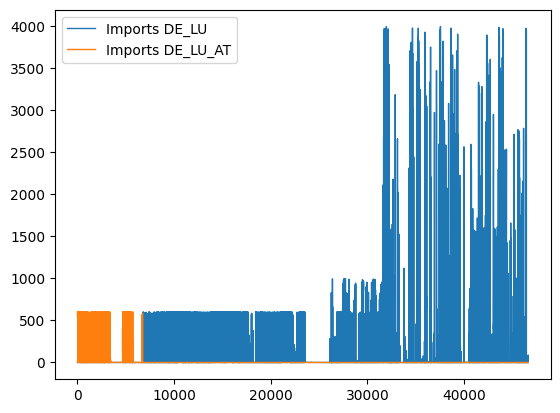

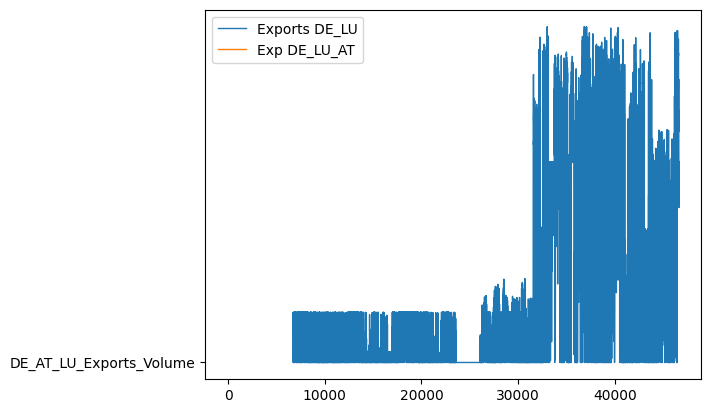

In [4]:
plt.plot(df['DE_LU'], linewidth = 1, label = 'Imports DE_LU')
plt.plot(df['DE_AT_LU'], linewidth = 1, label = 'Imports DE_LU_AT')
plt.legend()
plt.show()
plt.plot(df['DE_LU_Exports_Volume'], linewidth = 1, label = 'Exports DE_LU')
plt.plot(['DE_AT_LU_Exports_Volume'], linewidth = 1, label = 'Exp DE_LU_AT')
plt.legend()
plt.show()

In [5]:
df[(df['DE_AT_LU'].isna()) & (df['DE_LU'].isna())]

,Timestamp,DE_AT_LU,DE_LU,DK_1,SE_4,DE_AT_LU_Exports_Volume,DE_LU_Exports_Volume,DK_1_Exports_Volume,SE_4_Exports_Volume,Day_Ahead_Prices,Forecasted Load,Actual Load,Solar,Wind Offshore,Wind Onshore,TTF=F_Price,CFI2Z3_Price,CO2_prices_Price
46631,2023-04-19 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df[(df['DE_LU_Exports_Volume'].isna()) & (df['DE_AT_LU_Exports_Volume'].isna())]

,Timestamp,DE_AT_LU,DE_LU,DK_1,SE_4,DE_AT_LU_Exports_Volume,DE_LU_Exports_Volume,DK_1_Exports_Volume,SE_4_Exports_Volume,Day_Ahead_Prices,Forecasted Load,Actual Load,Solar,Wind Offshore,Wind Onshore,TTF=F_Price,CFI2Z3_Price,CO2_prices_Price
46631,2023-04-19 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
cols_na = ['DE_LU_Exports_Volume', 'DE_AT_LU_Exports_Volume', 'DE_AT_LU', 'DE_LU']
for col in cols_na:
    df[col].fillna(0, inplace = True)

df['DE_LU_corr'] = df['DE_AT_LU'] + df['DE_LU']
df.drop(['DE_AT_LU', 'DE_LU'], axis = 1, inplace = True)

df['DE_LU_Exports_Volume_corr'] = df['DE_LU_Exports_Volume'] + df['DE_AT_LU_Exports_Volume']
df.drop(['DE_LU_Exports_Volume', 'DE_AT_LU_Exports_Volume'], axis = 1, inplace = True)

In [8]:
df.isna().sum()

Timestamp                        0
DK_1                             1
SE_4                             1
DK_1_Exports_Volume              1
SE_4_Exports_Volume              1
Day_Ahead_Prices                 0
Forecasted Load                  1
Actual Load                      1
Solar                            1
Wind Offshore                    1
Wind Onshore                     1
TTF=F_Price                  45298
CFI2Z3_Price                 45269
CO2_prices_Price             45345
DE_LU_corr                       0
DE_LU_Exports_Volume_corr        0
dtype: int64

In [9]:
df = get_dt_info(df, 'Timestamp', yr = True, qt = True, mo = True, date = True, day = True, wd = True, h = True)
df = get_dt_info(df, 'Date', w = True)
df.tail().T

,46627,46628,46629,46630,46631
Timestamp,2023-04-19 19:00:00,2023-04-19 20:00:00,2023-04-19 21:00:00,2023-04-19 22:00:00,2023-04-19 23:00:00
DK_1,105.0,43.0,6.0,0.0,NaN
SE_4,534.0,521.0,467.0,611.0,NaN
DK_1_Exports_Volume,31.0,0.0,185.0,385.0,NaN
SE_4_Exports_Volume,0.0,0.0,0.0,0.0,NaN
Day_Ahead_Prices,59.94,50.93,41.69,35.78,39.48
Forecasted Load,1528.0,1466.0,1361.0,1273.0,NaN
Actual Load,1530.0,1480.0,1390.0,1320.0,NaN
Solar,2.0,0.0,0.0,0.0,NaN
Wind Offshore,804.0,850.0,861.0,849.0,NaN


## Differentiate business and non-business days

In [10]:
# calendar of holidays in DK
dk_bus = pd.tseries.offsets.CustomBusinessDay(calendar = holidays.DK(years = [2018, 2023]))

# range of business days, excluding weekends and holidays
dk_bus_days = pd.bdate_range(min(df['Date']), max(df['Date']), freq = dk_bus)
df['business'] = df['Date'].isin(dk_bus_days)

In [11]:
df.tail().T

,46627,46628,46629,46630,46631
Timestamp,2023-04-19 19:00:00,2023-04-19 20:00:00,2023-04-19 21:00:00,2023-04-19 22:00:00,2023-04-19 23:00:00
DK_1,105.0,43.0,6.0,0.0,NaN
SE_4,534.0,521.0,467.0,611.0,NaN
DK_1_Exports_Volume,31.0,0.0,185.0,385.0,NaN
SE_4_Exports_Volume,0.0,0.0,0.0,0.0,NaN
Day_Ahead_Prices,59.94,50.93,41.69,35.78,39.48
Forecasted Load,1528.0,1466.0,1361.0,1273.0,NaN
Actual Load,1530.0,1480.0,1390.0,1320.0,NaN
Solar,2.0,0.0,0.0,0.0,NaN
Wind Offshore,804.0,850.0,861.0,849.0,NaN


# Imputation

In [12]:
# check for NaN values
for col in df.columns:
    a = df[col].isna().sum()
    if a > 0:
        b = df[(df[col].isna()) & (df['business'] == True)]
        print(col, a, 'of which', len(b), 'in', len(b['Date'].unique()),'business days')

DK_1 1 of which 1 in 1 business days
SE_4 1 of which 1 in 1 business days
DK_1_Exports_Volume 1 of which 1 in 1 business days
SE_4_Exports_Volume 1 of which 1 in 1 business days
Forecasted Load 1 of which 1 in 1 business days
Actual Load 1 of which 1 in 1 business days
Solar 1 of which 1 in 1 business days
Wind Offshore 1 of which 1 in 1 business days
Wind Onshore 1 of which 1 in 1 business days
TTF=F_Price 45298 of which 31978 in 1388 business days
CFI2Z3_Price 45269 of which 31949 in 1388 business days
CO2_prices_Price 45345 of which 32025 in 1388 business days


In [13]:
# in most cases, 'TTF', 'CO2' and 'coal' NaN are in non-business days, where the price is the same as the last business day --> ffill
for col in ['TTF=F_Price', 'CO2_prices_Price','CFI2Z3_Price']:
    df[col].fillna(method = 'ffill', inplace = True)

In [14]:
# check for NaN values
for col in df.columns:
    a = df[col].isna().sum()
    if a > 0:
        b = df[(df[col].isna()) & (df['business'])]
        print(col, a, 'of which', len(b), 'in', len(b['Date'].unique()),'business days')

DK_1 1 of which 1 in 1 business days
SE_4 1 of which 1 in 1 business days
DK_1_Exports_Volume 1 of which 1 in 1 business days
SE_4_Exports_Volume 1 of which 1 in 1 business days
Forecasted Load 1 of which 1 in 1 business days
Actual Load 1 of which 1 in 1 business days
Solar 1 of which 1 in 1 business days
Wind Offshore 1 of which 1 in 1 business days
Wind Onshore 1 of which 1 in 1 business days
TTF=F_Price 216 of which 144 in 6 business days
CFI2Z3_Price 120 of which 96 in 4 business days
CO2_prices_Price 216 of which 144 in 6 business days


In [15]:
idx_drop = []
# idx2 = []
for col in ['TTF=F_Price', 'CO2_prices_Price','CFI2Z3_Price']:
    idx = df[df[col].isna()]['Date'].unique()
    idx_drop.append(idx)
    print(col, idx)
    # idx_drop.append(df[df[col].isna()]['Date'].unique()[0])

idx_drop = [item for sublist in idx_drop for item in sublist]
# idx_drop = set(idx_drop)

TTF=F_Price <DatetimeArray>
['2017-12-24 00:00:00', '2017-12-25 00:00:00', '2017-12-26 00:00:00',
 '2017-12-27 00:00:00', '2017-12-28 00:00:00', '2017-12-29 00:00:00',
 '2017-12-30 00:00:00', '2017-12-31 00:00:00', '2018-01-01 00:00:00']
Length: 9, dtype: datetime64[ns]
CO2_prices_Price <DatetimeArray>
['2017-12-24 00:00:00', '2017-12-25 00:00:00', '2017-12-26 00:00:00',
 '2017-12-27 00:00:00', '2017-12-28 00:00:00', '2017-12-29 00:00:00',
 '2017-12-30 00:00:00', '2017-12-31 00:00:00', '2018-01-01 00:00:00']
Length: 9, dtype: datetime64[ns]
CFI2Z3_Price <DatetimeArray>
['2017-12-24 00:00:00', '2017-12-25 00:00:00', '2017-12-26 00:00:00',
 '2017-12-27 00:00:00', '2017-12-28 00:00:00']
Length: 5, dtype: datetime64[ns]


In [16]:
# these NaNs are at the beginning of the df and consecutive days
# we drop all the rows for those days, for the sake of completeness
df.drop(df[df['Date'].isin(idx_drop)].index, inplace = True)

In [17]:
df.head().T

,216,217,218,219,220
Timestamp,2018-01-02 00:00:00,2018-01-02 01:00:00,2018-01-02 02:00:00,2018-01-02 03:00:00,2018-01-02 04:00:00
DK_1,383.0,589.0,557.0,487.0,580.0
SE_4,0.0,0.0,0.0,0.0,0.0
DK_1_Exports_Volume,0.0,0.0,0.0,0.0,0.0
SE_4_Exports_Volume,808.0,1019.0,926.0,784.0,756.0
Day_Ahead_Prices,18.12,14.99,17.79,24.51,17.82
Forecasted Load,1258.0,1188.0,1167.0,1187.0,1235.0
Actual Load,1245.0,1203.0,1178.0,1180.0,1247.0
Solar,0.0,0.0,0.0,0.0,0.0
Wind Offshore,231.0,181.0,134.0,73.0,44.0


In [18]:
# check for NaN values
cols_na = []
for col in df.columns:
    a = df[col].isna().sum()
    if a > 0:
        cols_na.append(col)
        b = df[df[col].isna()]['Date'].unique()
        print(col, a, '\nbusiness days', len(b), b)

DK_1 1 
business days 1 <DatetimeArray>
['2023-04-19 00:00:00']
Length: 1, dtype: datetime64[ns]
SE_4 1 
business days 1 <DatetimeArray>
['2023-04-19 00:00:00']
Length: 1, dtype: datetime64[ns]
DK_1_Exports_Volume 1 
business days 1 <DatetimeArray>
['2023-04-19 00:00:00']
Length: 1, dtype: datetime64[ns]
SE_4_Exports_Volume 1 
business days 1 <DatetimeArray>
['2023-04-19 00:00:00']
Length: 1, dtype: datetime64[ns]
Forecasted Load 1 
business days 1 <DatetimeArray>
['2023-04-19 00:00:00']
Length: 1, dtype: datetime64[ns]
Actual Load 1 
business days 1 <DatetimeArray>
['2023-04-19 00:00:00']
Length: 1, dtype: datetime64[ns]
Solar 1 
business days 1 <DatetimeArray>
['2023-04-19 00:00:00']
Length: 1, dtype: datetime64[ns]
Wind Offshore 1 
business days 1 <DatetimeArray>
['2023-04-19 00:00:00']
Length: 1, dtype: datetime64[ns]
Wind Onshore 1 
business days 1 <DatetimeArray>
['2023-04-19 00:00:00']
Length: 1, dtype: datetime64[ns]


In [19]:
df.drop(df[df['Date'] == max(df['Date'])].index, inplace = True)

In [20]:
# check for NaN values
cols_na = []
for col in df.columns:
    a = df[col].isna().sum()
    if a > 0:
        cols_na.append(col)
        b = df[df[col].isna()]['Date'].unique()
        print(col, a, '\nbusiness days', len(b), b)

In [21]:
df_temp = df.copy()
# df_temp[(df_temp['Hour'] == 17) & ('2020-09-03'< df_temp['Date']) & (df_temp['Date'] <'2020-09-15')]

df_temp.isna().sum()

Timestamp                    0
DK_1                         0
SE_4                         0
DK_1_Exports_Volume          0
SE_4_Exports_Volume          0
Day_Ahead_Prices             0
Forecasted Load              0
Actual Load                  0
Solar                        0
Wind Offshore                0
Wind Onshore                 0
TTF=F_Price                  0
CFI2Z3_Price                 0
CO2_prices_Price             0
DE_LU_corr                   0
DE_LU_Exports_Volume_corr    0
Year                         0
Quarter                      0
Month                        0
Date                         0
Day                          0
Weekday                      0
Hour                         0
Week                         0
business                     0
dtype: int64

In [22]:
max(df_temp[df_temp['Solar'].isna()]['Date'])

ValueError: max() arg is an empty sequence

In [ ]:
# for i in range(24):
#     check = df_temp[df_temp['Hour'] == i][cols_na].rolling(30, min_periods = 1, closed = 'left', axis = 'rows').mean()
#     df_temp[cols_na].fillna(value = check, inplace = True)
#     check = df_temp[df_temp['Hour'] == i][cols_na].rolling(24, min_periods = 1, closed = 'left', axis = 'rows').mean()
#     df_temp[cols_na].fillna(value = check, inplace = True)
#     check = df_temp[df_temp['Hour'] == i][cols_na].rolling(24, min_periods = 1, closed = 'left', axis = 'rows').mean()
#     df_temp[cols_na].fillna(value = check, inplace = True)

In [ ]:
d = dict(tuple(df_temp.groupby('Hour')))
df_temp=pd.DataFrame(data=None)
    #split in 24 timestamps/hours
for i in range(24):
    for j in cols_na:
        d[i][j]=d[i][j].fillna(d[i][j].rolling(7,min_periods=1).mean().round(1))
        d[i][j]=d[i][j].fillna(d[i][j].rolling(14,min_periods=1).mean().round(1))
        d[i][j]=d[i][j].fillna(method='pad')
    if i==0:
        df_temp=d[i]
    else:
        df_temp=pd.concat([df_temp,d[i]])
df_temp=df_temp.sort_values('Timestamp')
df_temp.isna().sum()

In [ ]:
cols_na

In [ ]:
df_temp[]

In [ ]:
# check for NaN values
for col in df_temp.columns:
    a = df_temp[col].isna().sum()
    if a > 0:
        b = df_temp[df_temp[col].isna()]['Date'].unique()
        print(col, a, '\nbusiness days', len(b), b)

In [ ]:
df_temp['Wind Total'] = df_temp['Wind Offshore'] + df_temp['Wind Onshore']
df_temp.drop(['Wind Offshore', 'Wind Onshore'], axis = 1, inplace = True)

In [ ]:
df_temp.to_csv('./data/DK_2_filled.csv', index = False)

# Lagging

In [ ]:
df_lag = pd.DataFrame(df_temp['Day-ahead prices'].copy())
df_lag['DAP-lag24'] = df_lag['Day-ahead prices'].shift(24) # 1 day
df_lag['DAP-lag25'] = df_lag['Day-ahead prices'].shift(25) # 25 h
df_lag['DAP-lag26'] = df_lag['Day-ahead prices'].shift(26) # 26 h
df_lag['DAP-lag27'] = df_lag['Day-ahead prices'].shift(27) # 27 h
df_lag['DAP-lag28'] = df_lag['Day-ahead prices'].shift(28) # 28 h
df_lag['DAP-lag29'] = df_lag['Day-ahead prices'].shift(29) # 29 h
df_lag['DAP-lag30'] = df_lag['Day-ahead prices'].shift(30) # 30 h
df_lag['DAP-lag31'] = df_lag['Day-ahead prices'].shift(31) # 31 h
df_lag['DAP-lag32'] = df_lag['Day-ahead prices'].shift(32) # 32 h
df_lag['DAP-lag33'] = df_lag['Day-ahead prices'].shift(33) # 33 h
df_lag['DAP-lag34'] = df_lag['Day-ahead prices'].shift(34) # 34 h
df_lag['DAP-lag35'] = df_lag['Day-ahead prices'].shift(35) # 35 h
df_lag['DAP-lag36'] = df_lag['Day-ahead prices'].shift(36) # 36 h
df_lag['DAP-lag48'] = df_lag['Day-ahead prices'].shift(24*2) # 2 days
df_lag['DAP-lag72'] = df_lag['Day-ahead prices'].shift(24*3) # 2 days
df_lag['DAP-lag168'] = df_lag['Day-ahead prices'].shift(24*7) # 1 week
df_lag['DAP-lag720'] = df_lag['Day-ahead prices'].shift(24*30) # 1 month
df_lag['DAP-lag2160'] = df_lag['Day-ahead prices'].shift(24*30*3) # 3 months
df_lag['DAP-lag8760'] = df_lag['Day-ahead prices'].shift(24*365) # 1 year
df_lag['DAP-lag-168'] = df_lag['Day-ahead prices'].shift(-24*7) # 1 week ahead

In [ ]:
df_lag.head()

In [ ]:
plt.figure(figsize = (10,10))
matrix = df_lag.corr().round(2)
sns.heatmap(matrix, annot=True)
plt.title('Auto-correlation for specific lags')
plt.show()

In [ ]:
lags = [24, 36, 48, 72, 168, -168]
lags_names = ['DAP-lag'+str(lag) for lag in lags]

In [ ]:
df_lag = df_temp.drop(['Timestamp'], axis =  1)
for lag, name in zip(lags, lags_names):
    df_lag[name] = df_lag['Day-ahead prices'].shift(lag)

In [ ]:
matrix = df_lag.corr().round(1)

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(matrix, annot=True)
plt.title('Auto-correlation for specific lags')
plt.show()

In [ ]:
df_lag.isna().sum()

In [ ]:
idx_drop = []
for col in lags_names:
    print(col, df_lag[df_lag[col].isna()]['Date'].unique())
    idx_drop=(df_lag[df_lag[col].isna()]['Date'].unique())
    df_lag.drop(df_lag[df_lag['Date'].isin(idx_drop)].index, inplace = True)





In [ ]:
df_lag.isna().sum()

In [ ]:
df_lag.to_csv('./data/DK_2_lagged.csv', index = False)

# PCA

In [ ]:
df_lag_nan = df_lag.dropna(how = 'any', axis = 'index')

In [ ]:
pca = PCA()
pca.fit(df_lag_nan)
print(pca.explained_variance_ratio_.cumsum())

## Log transform

$\log$ can't deal with negative values, thus, check how many there are:

In [ ]:
df_temp[df_temp['Day-ahead prices'] < 0].describe()

In [ ]:
plt.plot(df_temp[df_temp['Day-ahead prices'] >= 0]['Day-ahead prices'], label = 'Positive', linewidth = 0, marker = 'o', ms = 0.5)
plt.plot(df_temp[df_temp['Day-ahead prices'] < 0]['Day-ahead prices'], label = 'Negative', linewidth = 0, marker = 'o', ms = 0.5)
plt.title('Day-ahead prices\Time-series')
plt.xlabel('Time')
plt.ylabel('Price\€/MWh')
plt.legend()
plt.show()

In [ ]:
df_temp['Day-ahead prices'].plot.hist(bins = 100)
plt.xlabel('Price\n€/MWh')
plt.title('Day-ahead prices\nHistogram')
plt.show()

In [ ]:
df_log = df_temp[df_temp['Day-ahead prices'] > 0].copy()
df_log['Day-ahead prices log'] = np.log(df_log['Day-ahead prices'])

In [ ]:
df_log['Day-ahead prices log'].plot.hist(bins = 100)
plt.xlabel('Price\n€/MWh')
plt.title('log(Day-ahead prices)\nHistogram')
plt.show()